# Data Analysis using XGBoost

In [1]:
%pylab inline
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from lib import XGBHelper as xgbh
import pandas as pd

from lib.logger import logger
xgb.__version__

Populating the interactive namespace from numpy and matplotlib


'1.4.0'

In [2]:
!ls ../data

164 172 248


In [3]:
df_list=[]

for section in [164,172,248]:
    filename='../data/%d/puntas.csv'%section
    df=pd.read_csv(filename)
    #df['section']=section
    print(section,df.shape)
    df_list.append(df)
len(df_list)

164 (3814, 42)
172 (5504, 42)
248 (5000, 42)


3

In [6]:
full_df=pd.concat(df_list)
full_df.shape

(14318, 42)

In [7]:
full_df.columns

Index(['animal', 'section', 'index', 'label', 'area', 'height2', 'width2',
       'row', 'col', 'corr', 'energy', 'h0', 'h1', 'h2', 'h3', 'h4', 'h5',
       'h6', 'm00', 'm10', 'm01', 'm20', 'm11', 'm02', 'm30', 'm21', 'm12',
       'm03', 'mu20', 'mu11', 'mu02', 'mu30', 'mu21', 'mu12', 'mu03', 'nu20',
       'nu11', 'nu02', 'nu30', 'nu21', 'nu12', 'nu03'],
      dtype='object')

In [38]:
df=pd.DataFrame(full_df)
drops = ['animal', 'section', 'index', 'label', 'row', 'col'] 

## Setting Parameters for XG Boost
* Maximum Depth of the Tree = 3 _(maximum depth of each decision trees)_
* Step size shrinkage used in update to prevents overfitting = 0.3 _(how to weigh trees in subsequent iterations)_
* Maximum Number of Iterations = 1000 _(total number trees for boosting)_
* Early Stop if score on Validation does not improve for 5 iterations

[Full description of options](https://xgboost.readthedocs.io/en/latest//parameter.html)

In [39]:
def createDM(df):
    labels=df['label']
    features=df.drop(drops,axis=1)
    return xgb.DMatrix(features, label=labels)

def split_data(df,frac=0.5):
    train = df.sample(frac = 0.5)
    test  = df.drop(train.index)

    trainDM=createDM(train)
    testDM=createDM(test)
    AllDM=createDM(df)
    return trainDM,testDM,AllDM
trainDM,testDM,AllDM=split_data(df)

In [40]:
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.3      # shrinkage parameter
#param['silent'] = 0     # not silent
param['objective'] = 'binary:logistic'
param['nthread'] = 7 # Number of threads used
param['eval_metric'] = 'logloss' #['error','logloss']

print(param)
evallist = [(trainDM, 'train'), (testDM, 'eval')]

{'max_depth': 3, 'eta': 0.3, 'objective': 'binary:logistic', 'nthread': 7, 'eval_metric': 'logloss'}


In [41]:
# %load lib/Logger.py
import pandas as pd

class logger:
    """A helper class for defining a logger function and for parsing the
log, assuming it is created by XGBoost.
    Typical use:

    Logger=logger()
    logall=Logger.get_logger()

    bst = xgb.train(plst, dtrain, num_round, evallist, verbose_eval=False, callbacks=[logall])
    D=Logger.parse_log() #returns a dataframe with the logs.
    """
    def __init__(self):
        self.log=[]
         
    def get_logger(self):
        def logall(*argv,**argc):
            self.log.append(*argv)
        return logall

    def parse_log(self,ax=None):
        """ parse the log and generate plots"""
        D={'iter':[]}
        for _env in self.log:
            current_err={key:val for key,val in _env.evaluation_result_list}
            D['iter'].append(_env.iteration)
            for k in current_err.keys():
                if k in D:
                    D[k].append(current_err[k])
                else:
                    D[k]=[current_err[k]]
        for k in list(D.keys()):
            if len(D[k])==0:
                del D[k]

        df=pd.DataFrame(D)
        df=df.set_index('iter')
        test_col=[c for c in df.columns if 'eval' in c][0]
        print('test column=',test_col)
        _min=df[test_col].min()
        index_min=df[test_col].idxmin()
        title='min of %s=%f at %d'%(test_col,_min,index_min)
        if not ax is None:
            df.plot(grid=True,title=title,ax=ax)  
        return df


In [42]:
def test_xgboost(depth=4,num_round=100):
    param['max_depth']= depth   # depth of tree
    fig, axes = subplots(1,2,figsize=(12,5))
    i=0
    for _eval in ['error','logloss']:
        Logger=logger()
        logall=Logger.get_logger()  # Set logger to collect results
        param['eval_metric'] = _eval 
        bst = xgb.train(param, trainDM, num_round, evallist, verbose_eval=False, callbacks=[logall])
        df=Logger.parse_log(ax=axes[i])
        i+=1
    return bst
   

/Users/yoavfreund/miniforge3/lib/python3.9/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-error


/Users/yoavfreund/miniforge3/lib/python3.9/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-logloss


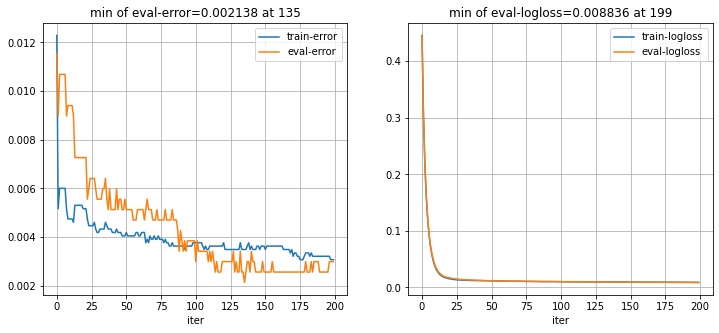

In [44]:
trainDM,testDM,allDM=split_data(df)
test_xgboost(depth=1,num_round=200)

/Users/yoavfreund/miniforge3/lib/python3.9/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-error


/Users/yoavfreund/miniforge3/lib/python3.9/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-logloss


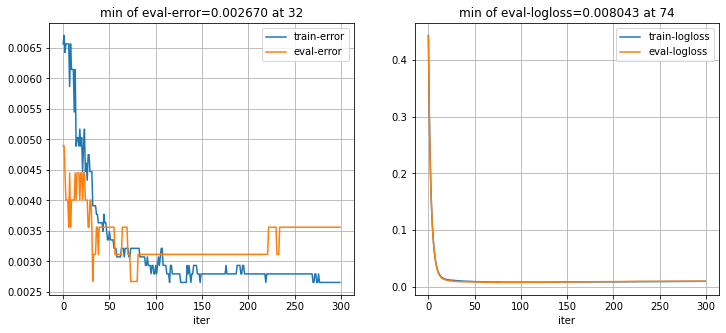

In [14]:
trainDM,testDM,allDM=split_data(df)
test_xgboost(depth=2,num_round=300)

/Users/yoavfreund/miniforge3/lib/python3.9/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-error


/Users/yoavfreund/miniforge3/lib/python3.9/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-logloss


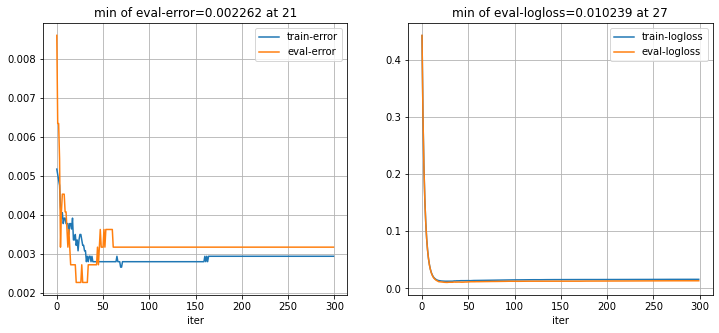

In [97]:
test_xgboost(depth=3,num_round=300)

/Users/yoavfreund/miniforge3/lib/python3.9/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/Users/yoavfreund/miniforge3/lib/python3.9/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-error
test column= eval-logloss


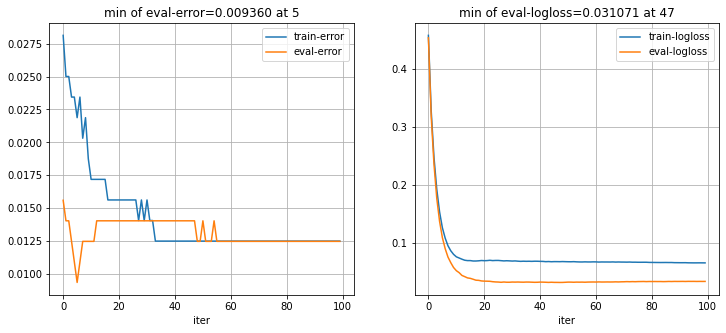

In [45]:
test_xgboost(depth=4,num_round=100)

/Users/yoavfreund/miniforge3/lib/python3.9/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-error


/Users/yoavfreund/miniforge3/lib/python3.9/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-logloss


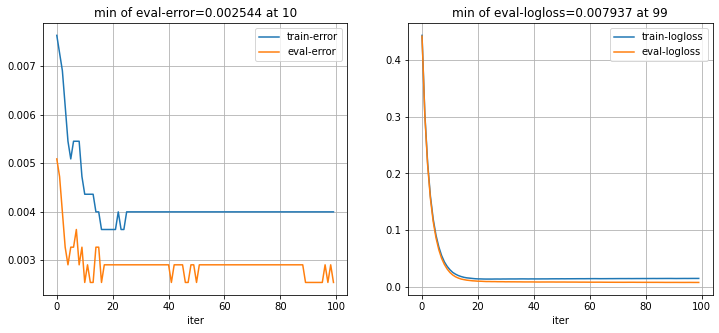

In [24]:
test_xgboost(depth=5,num_round=100)

## ROC graph
* Often false positive and false negatives have different cost.
* Different tradeoffs between false positives and false negatives can be gotten using different thresholds.
* The [ROC Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is a good way to visualize the tradeoffs. 

In [45]:

param={'max_depth': 1,
 'eta': 0.3,
 'objective': 'binary:logistic',
 'nthread': 7,
 'eval_metric': 'logloss'}
param

{'max_depth': 1,
 'eta': 0.3,
 'objective': 'binary:logistic',
 'nthread': 7,
 'eval_metric': 'logloss'}

In [46]:
num_round=200
bst = xgb.train(param, trainDM, num_round, evallist, verbose_eval=False)
y_pred = bst.predict(testDM, iteration_range=[1,bst.best_ntree_limit], output_margin=True)
y_pred.shape



(2333,)

In [47]:
y_test=testDM.get_label()

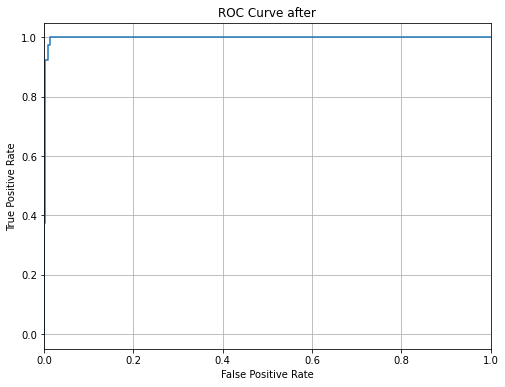

In [48]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
#plt.plot(fpr, tpr)
#fpr, tpr, thresholds = roc_curve(y_test, y_pred_1000)
plt.plot(fpr, tpr)
plt.xlim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve after")
plt.grid()
plt.show()

## Stability of the Margins.
Margins on the training set are predictive of margins of the test set, which is why margins are a better measure of performance than the training error.

In [49]:
y_test=testDM.get_label()
pos_preds=y_pred[y_test==1]
neg_preds=y_pred[y_test==0]
pos_preds.shape,neg_preds.shape

((40,), (2293,))

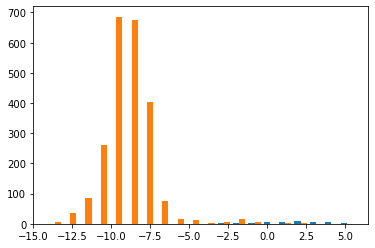

In [50]:
hist([pos_preds,neg_preds],bins=20);

In [51]:
aram={'max_depth': 1,
 'eta': 0.3,
 'objective': 'binary:logistic',
 'nthread': 7,
 'eval_metric': 'logloss'}

In [52]:
def gen_scale(n,reverse=False):
    s=arange(0,1,1/n)
    while s.shape[0] !=n:
        if s.shape[0]>n:
            s=s[:n]
        if s.shape[0]<n:
            s=arange(0,1,1/(n+0.1))
    if reverse:
        s=s[-1::-1]
    return s

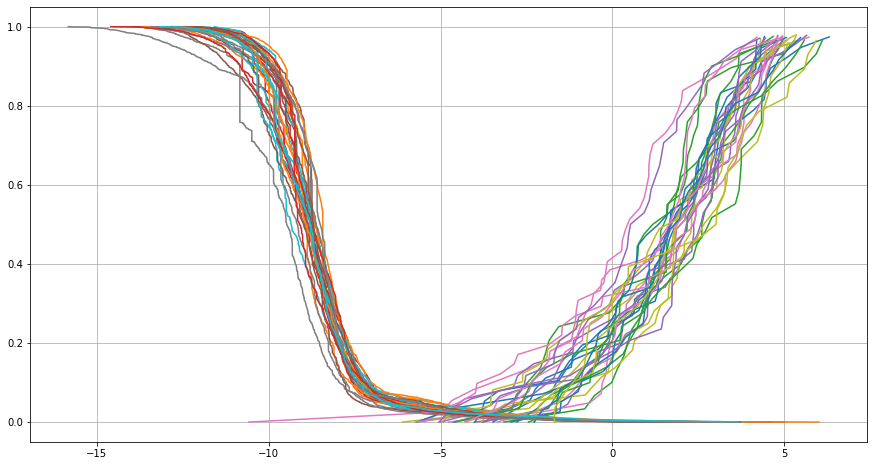

In [25]:
figure(figsize=[15,8])
num_round=200
bst_list=[]
for i in range(30):
    trainDM,testDM,allDM=split_data(df)
    bst = xgb.train(param, trainDM, num_round, evallist, verbose_eval=False)
    bst_list.append(bst)
    y_pred = bst.predict(testDM, iteration_range=[1,bst.best_ntree_limit], output_margin=True)
    y_test=testDM.get_label()
    pos_preds=y_pred[y_test==1]
    neg_preds=y_pred[y_test==0]
    pos_preds=sort(pos_preds)
    neg_preds=sort(neg_preds)
    plot(pos_preds,gen_scale(pos_preds.shape[0]));
    plot(neg_preds,gen_scale(neg_preds.shape[0],reverse=True))
grid()

In [53]:
import pickle as pk
with open('../data/172/BoostedTrees.pkl','bw') as pkl_file:
    pk.dump(bst_list,pkl_file)
!ls -lh ../data/172/*.pkl

-rw-r--r--  1 yoavfreund  staff   741B Aug 30 19:38 ../data/172/BadExamples.pkl
-rw-r--r--  1 yoavfreund  staff   3.2M Aug 31 09:43 ../data/172/BoostedTrees.pkl
-rw-r--r--  1 yoavfreund  staff   228M Aug 31 09:18 ../data/172/extracted_cells.pkl


In [54]:
import pickle as pk
with open('../data/172/BoostedTrees.pkl','br') as pkl_file:
    bst_list=pk.load(pkl_file)

In [55]:
trainDM,testDM,AllDM=split_data(df)
labels=AllDM.get_label()
scores=np.zeros([df.shape[0],len(bst_list)])
for i in range(len(bst_list)):
    bst=bst_list[i]
    scores[:,i] = bst.predict(AllDM, iteration_range=[1,bst.best_ntree_limit], output_margin=True)

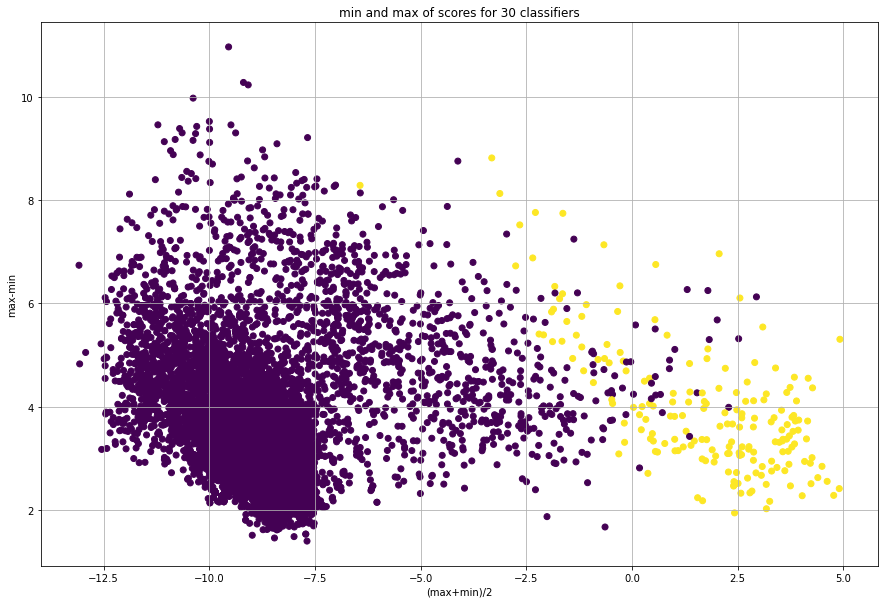

In [56]:
_max=np.max(scores,axis=1)
_min=np.min(scores,axis=1)

figure(figsize=[15,10])
scatter((_min+_max)/2,_max-_min,c=labels)
title('min and max of scores for 30 classifiers')
xlabel('(max+min)/2')
ylabel('max-min')
grid()

In [57]:
_mean=np.mean(scores,axis=1)
_std=np.std(scores,axis=1)

In [65]:
_mean.shape, full_df.shape, _std.shape
full_df['mean_score']=_mean
full_df['std_score']=_std
full_df=full_df.drop('sstd_score',axis=1)
full_df.columns

Index(['animal', 'section', 'index', 'label', 'area', 'height2', 'width2',
       'row', 'col', 'corr', 'energy', 'h0', 'h1', 'h2', 'h3', 'h4', 'h5',
       'h6', 'm00', 'm10', 'm01', 'm20', 'm11', 'm02', 'm30', 'm21', 'm12',
       'm03', 'mu20', 'mu11', 'mu02', 'mu30', 'mu21', 'mu12', 'mu03', 'nu20',
       'nu11', 'nu02', 'nu30', 'nu21', 'nu12', 'nu03', 'mean_score',
       'std_score'],
      dtype='object')

In [92]:
def decision(mean,std):
    if (np.abs(mean)+ 0.5)/7.5 < std/3.5:
        return 0
    elif mean>0:
        return 2
    else:
        return -2

In [93]:
predictions=[]
for i,row in full_df.iterrows():
    p=decision(float(row['mean_score']),float(row['std_score']))
    predictions.append(p)
full_df['predictions']=predictions

In [98]:
full_df.to_csv('demo_scores.csv')

In [99]:
full_df.columns

Index(['animal', 'section', 'index', 'label', 'area', 'height2', 'width2',
       'row', 'col', 'corr', 'energy', 'h0', 'h1', 'h2', 'h3', 'h4', 'h5',
       'h6', 'm00', 'm10', 'm01', 'm20', 'm11', 'm02', 'm30', 'm21', 'm12',
       'm03', 'mu20', 'mu11', 'mu02', 'mu30', 'mu21', 'mu12', 'mu03', 'nu20',
       'nu11', 'nu02', 'nu30', 'nu21', 'nu12', 'nu03', 'mean_score',
       'std_score', 'predictions'],
      dtype='object')

In [104]:
detection_df=full_df[full_df['predictions']!=-2]
detection_df = detection_df[['animal', 'section', 'row', 'col','label', 'mean_score',
       'std_score', 'predictions']]
detection_df.head()

,animal,section,row,col,label,mean_score,std_score,predictions
153,DK55,164,15213,24954,1,1.422074,1.097634,0
272,DK55,164,17250,22558,1,3.597950,0.620428,2
274,DK55,164,17246,21326,1,2.554182,0.824888,2
281,DK55,164,17277,21583,1,0.881989,0.883821,0
284,DK55,164,17282,21437,1,0.841280,1.330851,0


In [105]:
detection_df.to_csv('detections_DK55.csv',index=False)

In [106]:
!head detections_DK55.csv

animal,section,row,col,label,mean_score,std_score,predictions
DK55,164,15213,24954,1,1.4220740407705308,1.0976336713183832,0
DK55,164,17250,22558,1,3.5979496002197267,0.6204279457627662,2
DK55,164,17246,21326,1,2.5541820347309114,0.8248878663553816,2
DK55,164,17277,21583,1,0.8819890737533569,0.8838211162238286,0
DK55,164,17282,21437,1,0.8412798963487148,1.3308507659355266,0
DK55,164,17348,21143,1,2.7882171591122944,0.6182647294152305,2
DK55,164,17395,21391,1,2.8280847867329917,0.8258939460434237,2
DK55,164,17421,21854,1,1.3375499099493027,1.7155911445211938,0
DK55,164,17487,21297,1,-0.8865290536234777,1.6239270753035429,0


In [97]:
from collections import Counter
Counter(predictions)

Counter({-2: 14064, 0: 138, 2: 116})

No handles with labels found to put in legend.


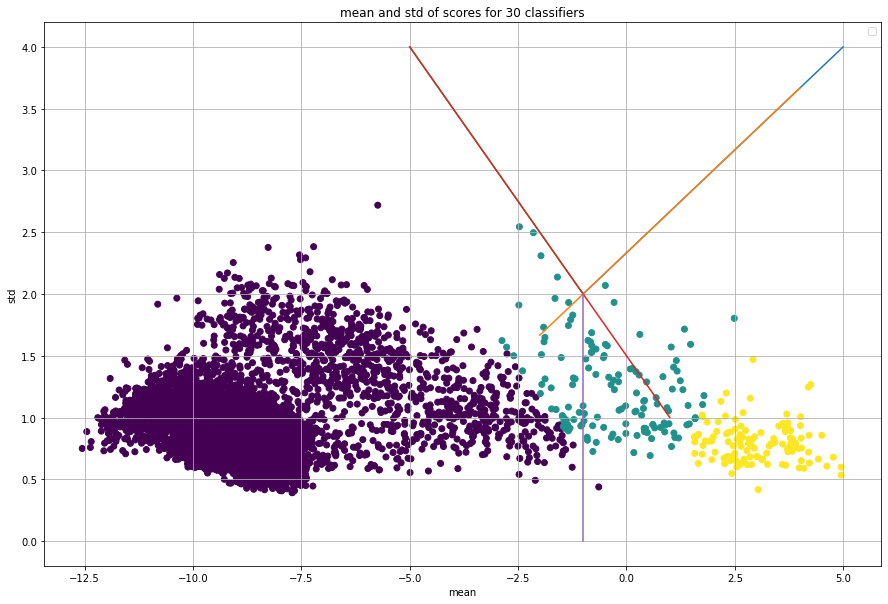

In [95]:
figure(figsize=[15,10])
scatter(_mean,_std,c=predictions)
plot([-1,5],[2,4])
a,b=solve(-1,5,2,4)
x=arange(-2,5)
plot(x,a+b*x)
plot([-1,-5],[2,4])
a,b=solve(-1,-5,2,4)
x=arange(-5,2)
plot(x,a+b*x)

plot([-1,-1],[2,0])
title('mean and std of scores for 30 classifiers')
xlabel('mean')
ylabel('std')
grid()

In [31]:
def solve(x1,x2,y1,y2):
    b=(y1-y2)/(x1-x2)
    a=0.5*(y1+y2-b*(x1+x2))
    return a,b

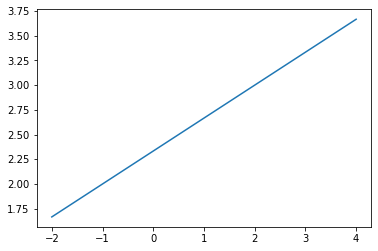

In [33]:
a,b=solve(-1,5,2,4)
x=arange(-2,5)
plot(x,a+b*x)

In [15]:
%pwd

'/Users/yoavfreund/projects/butons/XGBoost'

In [26]:
import pickle as pk
with open('../data/172/BoostedTrees.pkl','bw') as pkl_file:
    pk.dump(bst_list,pkl_file)
!ls -lh ../data/172/*.pkl

-rw-r--r--  1 yoavfreund  staff   2.2M Aug 16 10:53 ../data/172/BoostedTrees.pkl
-rw-r--r--  1 yoavfreund  staff   221M Aug 14 14:54 ../data/172/extracted_cells.pkl


In [ ]:
def plot_margins(_train_size):
    plt.figure(figsize=(8, 6))
    for i in range(10):
        trainDM,testDM=split_data(df)
        legends=[]
        # Use early_stopping_rounds=5 to enable early stopping
        for num_round in [100]:
            bst = xgb.train(param, trainDM, num_round, evallist, verbose_eval=False)
            y_pred = bst.predict(testDM, iteration_range=[0,bst.best_ntree_limit], output_margin=True)
            thresholds = sorted(np.unique(np.round(y_pred, 2)))
            error_cuv, error_ger = xgbh.get_error_values(y_pred, y_test, thresholds)
            legends += ['Cuviers %d'%num_round, 'Gervais %d'%num_round]
            _style=['y','g'] if num_round==100 else ['b', 'r']
            xgbh.get_margin_plot(error_cuv, error_ger, thresholds, legends = legends, style=_style)
        
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
        thr = thresholds/(np.max(thresholds) - np.min(thresholds))
    plt.title('data_size=%4.3f'%(X_train.shape[0]))
    plt.show()

In [ ]:
plot_margins(0.03)

In [ ]:
plot_margins(0.1)

In [ ]:
plot_margins(0.8)

## Per example variation analysis
The CDFs provide information on the variation of the aggregate. If we want to estimate of the confidence on a single examples we need to compute the variance **per example**

In [ ]:
data  = np.load("Data/processed_data_15mb.np")
data.shape

In [ ]:
def get_error_ranges(error_cuv_samp, error_ger_samp, thresholds_samp, num_chunks=20):
    error_cuv_bin = np.array(np.array(error_cuv_samp) * num_chunks, dtype=int)
    error_cuv_bin[error_cuv_bin == num_chunks] = num_chunks - 1
    error_ger_bin = np.array(np.array(error_ger_samp) * num_chunks, dtype=int)
    error_ger_bin[error_ger_bin == num_chunks] = num_chunks - 1
    
    min_cuv = np.zeros(num_chunks, dtype=float)
    max_cuv = np.zeros(num_chunks, dtype=float)
    min_ger = np.zeros(num_chunks, dtype=float)
    max_ger = np.zeros(num_chunks, dtype=float)
    
    normalizing_factor = (max(thresholds_samp) - min(thresholds_samp))
    
    for i in range(num_chunks):
        min_cuv[i] = thresholds_samp[np.min(np.where(error_cuv_bin == i))]/normalizing_factor
        max_cuv[i] = thresholds_samp[np.max(np.where(error_cuv_bin == i))]/normalizing_factor
        min_ger[i] = thresholds_samp[np.min(np.where(error_ger_bin == i))]/normalizing_factor
        max_ger[i] = thresholds_samp[np.max(np.where(error_ger_bin == i))]/normalizing_factor
            
    return min_cuv, max_cuv, min_ger, max_ger

In [ ]:
def generate_samples(data, size=500, num_chunks=20):
    for i in range(200):
        if i == 0:
            min_cuv = np.zeros(num_chunks, dtype=float)
            max_cuv = np.zeros(num_chunks, dtype=float)
            min_ger = np.zeros(num_chunks, dtype=float)
            max_ger = np.zeros(num_chunks, dtype=float)
        
        #Sampling Random indices for selection
        samp_indices = np.random.randint(len(data), size=size)
        
        #Test data and labels
        X_samp = data[samp_indices, :-1]
        y_samp = np.array(data[samp_indices, -1], dtype=int)
        
        #Test predictions
        dsamp = xgb.DMatrix(X_samp, label=y_samp)    
        y_samp_pred = bst.predict(dsamp, iteration_range=[0,bst.best_ntree_limit], output_margin=True)

        thresholds_samp = sorted(np.unique(np.round(y_samp_pred, 2)))
        error_cuv_samp, error_ger_samp = xgbh.get_error_values(y_samp_pred, y_samp, thresholds_samp)
        
        min_cuv_samp, max_cuv_samp, min_ger_samp, max_ger_samp = get_error_ranges(error_cuv_samp, error_ger_samp, thresholds_samp)
        
        if i == 0:
            min_cuv = min_cuv_samp
            max_cuv = max_cuv_samp
            min_ger = min_ger_samp
            max_ger = max_ger_samp
        else:
            min_cuv[min_cuv > min_cuv_samp] = min_cuv_samp[min_cuv > min_cuv_samp]
            max_cuv[max_cuv < max_cuv_samp] = max_cuv_samp[max_cuv < max_cuv_samp]
            min_ger[min_ger > min_ger_samp] = min_ger_samp[min_ger > min_ger_samp]
            max_ger[max_ger < max_ger_samp] = max_ger_samp[max_ger < max_ger_samp]         
    
    for i in range(20):
        plt.plot([min_cuv[i], max_cuv[i]], [i/20.0, i/20.0], 'b')
        plt.plot([min_ger[i], max_ger[i]], [i/20.0, i/20.0], 'r')
    

* Each line segment represents the average man and std of a set of examples, stratified by thei score.

In [ ]:
plt.figure(figsize=(8, 6))
#legends = ['Cuviers', 'Gervais']

#Best thresholds from the ROC Analysis
thr_lower_index = np.min(np.where((tpr > 0.95)))
thr_upper_index = np.max(np.where((tpr  < 0.6)))
thr_lower, thr_upper = thresholds[thr_lower_index], thresholds[thr_upper_index]
thr_lower_norm = thr_lower/(np.max(thresholds) - np.min(thresholds))
thr_upper_norm = thr_upper/(np.max(thresholds) - np.min(thresholds))
print("Thresholds (lower, upper):", thr_lower_norm, thr_upper_norm)


generate_samples(data, num_chunks=20)

#xgbh.get_margin_plot(error_cuv_100, error_ger_100, thresholds_100, legends = legends, style=['y', 'g'])
plt.plot([thr_lower_norm, thr_lower_norm], [0, 1], 'm:')
plt.plot([thr_upper_norm, thr_upper_norm], [0, 1], 'm:')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.xlabel('Score')
plt.ylabel('CDF')
legends = ['Cuviers_100', 'Gervais_100']
plt.legend(legends)
plt.show()

# Summary
* We saw how PCA+Boosting are used to solve a real-world problem.

* We saw several ways to quantify and understand the behaviour of boosted trees.
   * Train and test error
   * Train and test loss
   * ROC curves
   * Stability of scores

* Next Time: **Neural Networks**